# Grid Search

__Import libraries__

In [1]:
# essential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
%matplotlib inline

# datasets
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ML algorithms
from sklearn.svm import SVC

- Now we want to improve the model's generalization performance by tuning its parameters.
- Finding the values of important parameters of a model, the one that provide the best generalization performace.
- One of methods to find these values is by doing Grid Search, which means trying all possible combinations of the parameter of interest.
- Considere the case of a kernel SVM with an RBF kernel. There are two important parameters: the kernel bandwidth, gamma and the regularization parameter C.

___

## Simple Grid Search

In [2]:
iris = load_iris()

In [3]:
# naive grid seach implementation
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}, size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

Size of training set: 112, size of test set: 38


In [4]:
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters. train on SVC
        svm = SVC(gamma=gamma, C=C).fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C' : C, 'gamma' : gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


---

## The Danger of Overfitting the Parameters and the Validation Set

- Given this result, we might be tempted to report that we found a model that performs with 97% accuracy on our dataset. However, this claim could be overly optimistic (or just wrong), for the following reason: we tried many different parameters and selected the one with best accuracy on the test set, but this accuracy won’t necessarily carry over to new data.
- One way to resolve this problem is to split the data again, so we have three sets: the training set to build the model, the validation (or development) set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters.

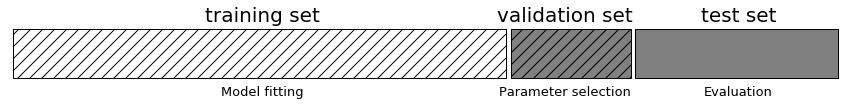

In [5]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a model
using the parameter settings we found, but now training on both the training data
and the validation data. This way, we can use as much data as possible to build our
model.

In [6]:
# split the data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# split the training+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {}, size of validation set: {}, size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 84, size of validation set: 28, size of test set: 38



In [7]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
# rebuild a model on the combing training and validation set
# and evaluate it on test set
svm = SVC(**best_parameters).fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 100, 'gamma': 0.001}
Test set score with best parameters: 0.97


The best score on the validation set is 96%: slightly lower than before, probably
because we used less data to train the model (X_train is smaller now because we split
our dataset twice). However, the score on the test set—the score that actually tells us
how well we generalize—is even lower, at 92%. So we can only claim to classify new
data 92% correctly, not 97% correctly as we thought before!

- Any choices made based on the test set accuracy 'leak' information from the test set into the model.
- Therefore it is important to keep a separate test set, which is only used for the final evaluation.
- It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a finalevaluation—this is even true for exploratory visualization.
- Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will resultin an overly optimistic estimate of how accurate the model is.

---

## Grid Search with Cross-Validation

- While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split.
- For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination.

In [8]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        scores = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute the mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C' : C, 'gamma' : gamma}

# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters).fit(X_trainval, y_trainval)

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


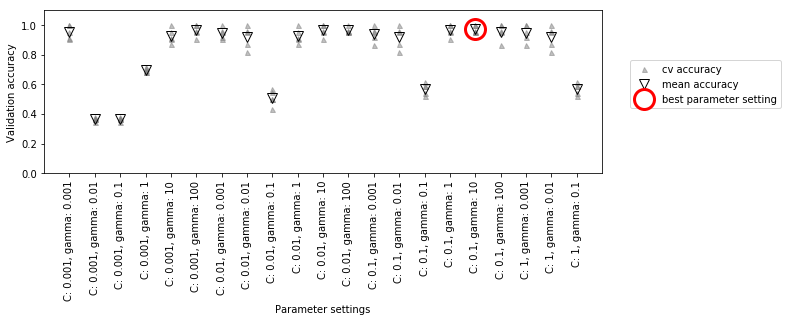

In [9]:
mglearn.plots.plot_cross_val_selection()

Cross-validation is a way to evaluate a given algorithm on a specific dataset. However, it is often used in conjunction with parameter search methods like grid search. For this reason, many people use the term cross-validation colloquially to refer to grid search with cross-validation. 

The overall process of splitting the data, running the grid search, and evaluating the
final parameters

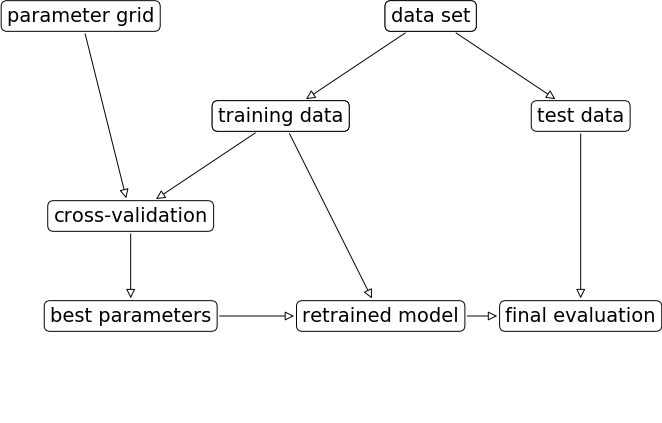

In [10]:
mglearn.plots.plot_grid_search_overview()

To use the GridSearchCV class, you first need to specify the
parameters you want to search over using a dictionary. GridSearchCV will then perform
all the necessary model fits. The keys of the dictionary are the names of parameters
we want to adjust (as given when constructing the model—in this case, C and
gamma), and the values are the parameter settings we want to try out. Trying the values
0.001, 0.01, 0.1, 1, 10, and 100 for C and gamma translates to the following
dictionary:

In [37]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid: {}".format(param_grid))

Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [38]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

GridSearchCV will use cross-validation in place of the split into a training and validation
set that we used before. However, we still need to split the data into a training
and a test set, to avoid overfitting the parameters:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

The grid_search object that we created behaves just like a classifier; we can call the
standard methods fit, predict, and score on it (Meta-estimator). However, when we call fit, it will
run cross-validation for each combination of parameters we specified in param_grid:

In [40]:
grid_search.fit(X_train, y_train)

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

- Fitting the GridSearchCV object not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance.
- What happens in GridSearch is the same to what we've been doing manually.

In [41]:
print("Test set score: {:.3f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.974


The important thing here is that we did not use the test set to choose the parameters. The parameters that were found are stored in the best_params_ attribute, and the best cross-validation accuracy (the mean accuracy
over the different splits for this parameter setting) is stored in best_score_.

In [42]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross validation score: {}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross validation score: 0.9732142857142857


Again, be careful not to confuse best_score_ with the generalization performance of the model as computed by the score method on the test set. Using the score method (or evaluating the output of the predict method) employs a model trained on the whole training set. The best_score_ attribute stores the mean cross-validation accuracy, with cross-validation performed on the training set.

In [43]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Analyzing the result of cross-validation

- It is a good idea to visualize th results of cross-validaion+grid-search.
- Grid searches are expensive to run, it is a good idea to start with a small grid.
- The results of a grid search can be found in the cv_results_ attribute, which is a dictionary storing all aspects of the search.

In [44]:
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the the 5 rows
display(results.head())

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Agus Ri

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001998,2.177846e-06,0.000800,0.000400,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.001999,1.093886e-03,0.000799,0.000400,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.003398,1.357226e-03,0.001198,0.000398,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.001599,8.002998e-04,0.000800,0.000400,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.000999,2.780415e-07,0.001199,0.000400,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


Each row in results corresponds to one particular parameter setting. For each setting, the results of all cross-validation splits are recorded, as well as the mean and standard deviation over all splits. As we were searching a two-dimensional grid of parameters (C and gamma), this is best visualized as a heat map. First we
extract the mean validation scores, then we reshape the scores so that the axes correspond
to C and gamma:

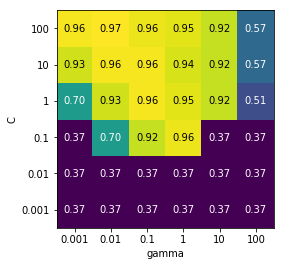

In [45]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

- Parameters in SVC are very important for obtaining good performance.
- Parameters C and gamma matter a lot, as adjusting them can change the accuracy from 40% to 96%.
- Additionally, the ranges we picked for the parameters are ranges in which we see significant changes in the outcome. It’s also important to note that the ranges for the parameters are large enough: the optimum values for each parameter are not on the edges of the plot.

C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


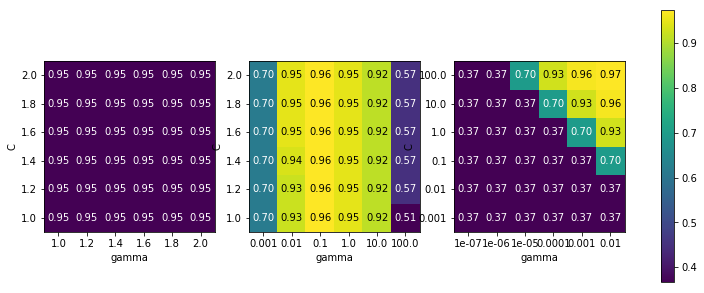

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
 
param_grid_linear = {'C': np.linspace(1, 2, 6),
'gamma': np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
'gamma': np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
    scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
    yticklabels=param_grid['C'], cmap="viridis", ax=ax)
    
plt.colorbar(scores_image, ax=axes.tolist())

- If no change in accuracy is visible over the different parameter settings, it could also be that a parameter is just not important at all. It is usually good to try very extreme values first, to see if there are any changes in the accuracy as a result of changing a parameter.
- We should no test different parameter ranges on the final test set. Evaluation of the test set should happen only once we know exactly what model we want to use.

### Search over spaces that are not grids

- In some cases, trying all possible combinations of all parameters as GridSearchCV usually does, is not a good idea.
- For example, SVC has a kernel parameter, and depending on which kernel is chosen, other parameters will be relevant. If kernel='linear', the model is linear, and only the C parameter is used.
- If kernel='rbf', both the C and gamma parameters are used (but not other parameters like degree).
- GridSearchCV allows the param_grid to be a list of dictionaries. Each dictionary in the list is expanded into an independent grid.

In [46]:
param_grid = [{'kernel' : ['rbf'],
               'C' : [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel' : ['linear'],
               'C' : [0.001, 0.01, 0.1, 1, 10, 100] }]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In the first grid, the kernel parameter is always set to 'rbf' (note that the entry for
kernel is a list of length one), and both the C and gamma parameters are varied. In the
second grid, the kernel parameter is always set to linear, and only C is varied.

In [47]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5).fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.973


C:\Users\Agus Richard Lubis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
results = pd.DataFrame(grid_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00159826,0.00159941,0.00919409,0.00599623,0.00219784,0.00339875,0.00199947,0.00139985,0.00139966,0.00199852,...,0.00159802,0.00119915,0.00199838,0.0023993,0.00139899,0.00159936,0.00159969,0.000999355,0.000998974,0.00119972
std_fit_time,0.000489707,0.00049035,0.0143913,0.00525,0.00146859,0.00195951,0.000631506,0.000489416,0.000489863,0.000894256,...,0.000798416,0.000399518,2.24367e-06,0.000487958,0.000488171,0.00119898,0.000490388,1.19305e-06,3.37175e-07,0.000400662
mean_score_time,0.00119948,0.00139775,0.000599909,0.000800419,0.000599623,0.00119853,0.000798798,0.000998402,0.000998878,0.000799227,...,0.000600243,0.00079937,0.00100017,0.00159984,0.000999784,0.000998878,0.000199986,0.000799942,0.000600052,0.000799561
std_score_time,0.000400305,0.000799227,0.000489829,0.000748278,0.000489591,0.00074731,0.0003994,7.4789e-07,4.90934e-07,0.000747704,...,0.000490103,0.000399685,1.39021e-06,0.000800693,1.34532e-06,8.86968e-07,0.000399971,0.000399972,0.00048994,0.000399781
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.521739,0.347826,0.826087,0.913043,0.956522,1,1


### Using different cross-validation strategies with grid seach

- Similarly to cross_val_score GridSearchCV uses stratified k-fold cross validation by default for classification and standard k-fold cross-validation for regression.
- However, we can also pass any cross-validation splittier to paramater cv.

### Nested cross-validation 

- In nested cross-validation, there is an outer loop over splits of the data into training and test sets. For each of them, a grid searchis run (which might result in different best parameters for each split in the outerloop). Then, for each outer split, the test set score using the best settings is reported.
- The result of this procedure is a list of scores—not a model, and not a parameter setting. The scores tell us how well a model generalizes, given the best parameters found by the grid. As it doesn’t provide a model that can be used on new data, nested crossvalidation is rarely used when looking for a predictive model to apply to future data.However, it can be useful for evaluating how well a given model works on a particular dataset.

In [51]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


The result of our nested cross-validation can be summarized as “SVC can achieve 98%
mean cross-validation accuracy on the iris dataset”—nothing more and nothing
less.

---

# IMPORTANT POINTS

- To find the best paramater of our model. So we can get a well performance and accuracy.
- We can make simple grid search by using for loop. Then we can get the best score on test set by doing fitting on training set, also get the best parameters.
- Better way of simple grid search is by splitting the data into three parts: training, validation and test set. 
    - First, split the data into train+validation and test set.
    - Split the data into training and validation set.
    - On traning set, we fit the model.
    - On validation set, we search for better score and parameters.
    - On test set, we perform final evaluation.
- Another better way (quite better):
    - First, split the data into train+validation and test set.
    - Use train+valid set to find score by using cross_val_score.
    - we average the score of cross_val_score, keep it if it is the best score.
    - Continue the loop like before simple grid search.
    - After we get the best score and best parameters. We train it again, then use test set for final evaluation.
- GridSearchCV: using meta-estimator implemented in scikit-learn.
    - Process 1 (without cross_val_score):
        - Split the data into training set and test set.
        - Specify the parameters by writting it in dictionary. ex: params_grid = { 'params1' : [1, 2, 3, 4, 5], 'params2' : [1, 2, 3, 4, 5]}.
        - Instantiate the GridSearchCV. ex: GridSearchCV(SVC(), params_grid, cv=5)
        - Fit the meta-estimator on training data. 
        - We can check the best parameters found on training set. By accessing grid_seach.best_params_ and best score by accessing grid_search.best_score_. In here the best score is what we get by using best parameters on validation set.
        - Inspect the performance using test set. Also we can check best_estimator_ attribute.
        - Get a better understanding of grid search by inspecting cv_results_.
        - Put the attribute as DataFrame.
        - Build an array of best_test_score, then reshape according to its size.
        - Visualize using heatmap.
    - Process 2 (with cross_val_score):
        - Same but, using cross_val_score.
        - This procedure is not returning meta-estimator.
    - Methods:
        - fit
        - predict
        - score
    - Parameters:
        - Model
        - Paramaters in form of dictionary.
        - cv
    - Attributes:
        - best_score_
        - best_params_
        - best_estimator_
        - cv_results_
- Parameters must be wide first to make sure that we won't miss best parameter. Then to make it more accurate, make the search parameters smaller.
- Downside(s):
    - Very expensive computation.

---

# Experiment

In [2]:
dataset = load_breast_cancer()

In [5]:
# split the data into training set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(dataset.data, dataset.target, 
                                                    random_state=0)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                 random_state=0)
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        svc = SVC(gamma=gamma, C=C).fit(X_train, y_train)
        score = svc.score(X_val, y_val)
        if score > best_score:
            best_score = score
            best_params = {'C' : C, 'gamma' : gamma}

In [8]:
best_params

{'C': 1, 'gamma': 0.001}

In [9]:
svc = SVC(**best_params).fit(X_trainval, y_trainval)
print("Test set score: {}".format(svc.score(X_test, y_test)))

Test set score: 0.9300699300699301


In [10]:
# split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, 
                                                   random_state=0)

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        scores = cross_val_score(SVC(gamma=gamma, C=C), X_train, y_train, cv=5)
        score = scores.mean()
        if score > best_score:
            best_score = score
            best_params = {'C' : C, 'gamma' : gamma}

In [11]:
best_params

{'C': 1, 'gamma': 0.001}

In [12]:
best_score

0.9224584717607973

In [13]:
svc = SVC(**best_params).fit(X_train, y_train)
print("Test set score: {}".format(svc.score(X_test, y_test)))

Test set score: 0.9300699300699301


In [15]:
params = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [17]:
grid_search = GridSearchCV(SVC(), params, cv=5).fit(X_train, y_train)

In [18]:
grid_search.best_score_

0.9225352112676056

In [21]:
grid_search.best_params_

{'C': 1, 'gamma': 0.001}

In [24]:
results = pd.DataFrame(grid_search.cv_results_)

In [28]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021185,1.041362e-02,0.009195,6.427386e-03,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
1,0.019388,3.003460e-03,0.004596,7.990858e-04,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
2,0.017387,4.894938e-04,0.004398,4.909918e-04,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
3,0.024186,7.489411e-04,0.005997,6.336923e-04,0.001,1,"{'C': 0.001, 'gamma': 1}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
4,0.023983,8.940961e-04,0.005397,4.903496e-04,0.001,10,"{'C': 0.001, 'gamma': 10}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
5,0.023984,6.330889e-04,0.005997,9.584308e-07,0.001,100,"{'C': 0.001, 'gamma': 100}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
6,0.021984,5.091228e-07,0.005596,4.899599e-04,0.001,1000,"{'C': 0.001, 'gamma': 1000}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
7,0.015588,4.900183e-04,0.003998,8.395585e-07,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
8,0.022184,3.995421e-04,0.005398,4.898075e-04,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711
9,0.023784,4.010110e-04,0.005396,4.902916e-04,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.627907,0.627907,0.623529,...,0.626761,0.002857,8,0.626471,0.626471,0.627566,0.627566,0.625731,0.626761,0.000711


In [26]:
scores = results['mean_test_score'].values.reshape(7, 7)